# Gaussian Process

src: https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/

- **GP** is a stochastic procss such that every finite collection of those random variables has a multivariate normal distribution [Wikipedia.com].
- A **stochastic process** is a collection of random variables indexed by time and space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image

## Multivariate Gaussian Distribution
Gaussian distribution with $\mu=[0,0]$ and $\Sigma=[[1,.6], [.6, 1]]$

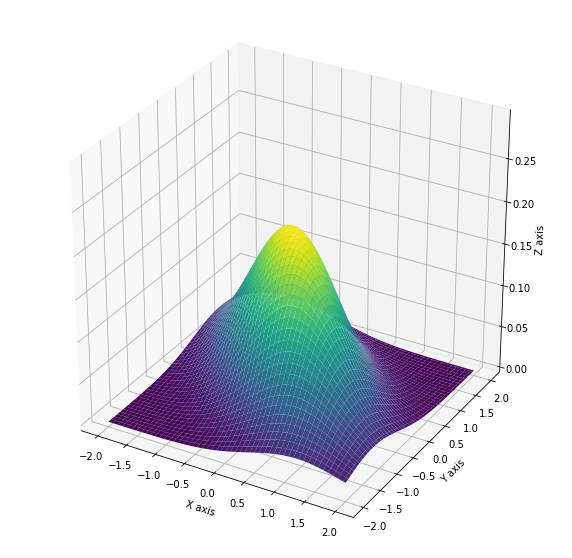

In [2]:
Image(filename='figs/mvgs.png', width=400)

### Marginal Gaussian: Gaussians make baby Gaussians
- Any marginal density of Gaussian is Gaussian
- Given
$$
    p(x,y) = \mathcal{N} (\mu=[\mu_x, \mu_y], \Sigma=[[s_x, s_{xy}], [s_{xy}, s_y]])
$$
$$
p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, s_x)
$$

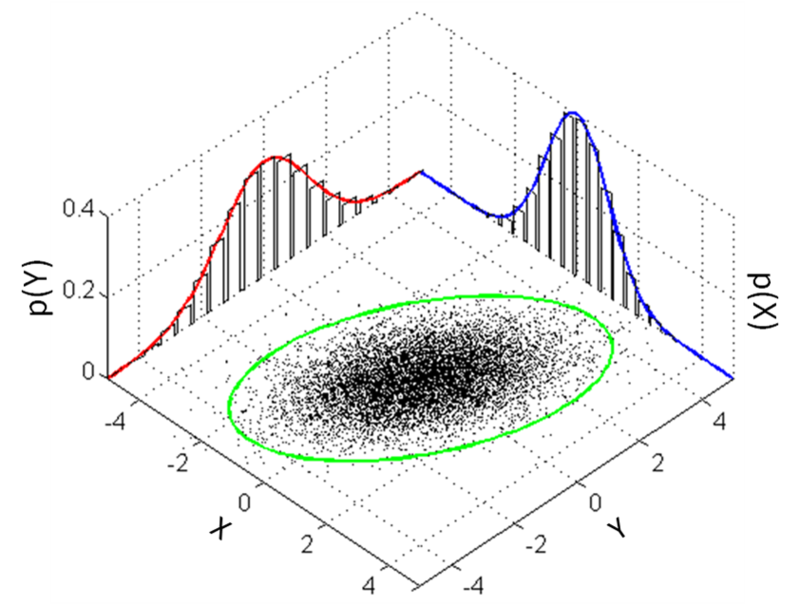

In [3]:
Image(filename='figs/marginal.png', width=500)

### Conditional Probability
$$
    p(x|y=y_0) = \mathcal{N}\big(\mu_x + s_{xy} s_y^{-1} (y_0 - \mu_y),  s_x - s_{xy} s_y^{-1} s_{xy}^T\big)
$$
- conditional mean: $\mu_{x|y=y_0} = \mu_x + s_{xy} s_y^{-1} (y_0 - \mu_y)$
- conditional covariance: $s_{x|y=y_0} = s_x - s_{xy} s_y^{-1} s_{xy}^T$

Below is a plot of $p(x_2|x_1=1)$, which shows how the conditional distribution also leads to a Gaussian distribution (red color).

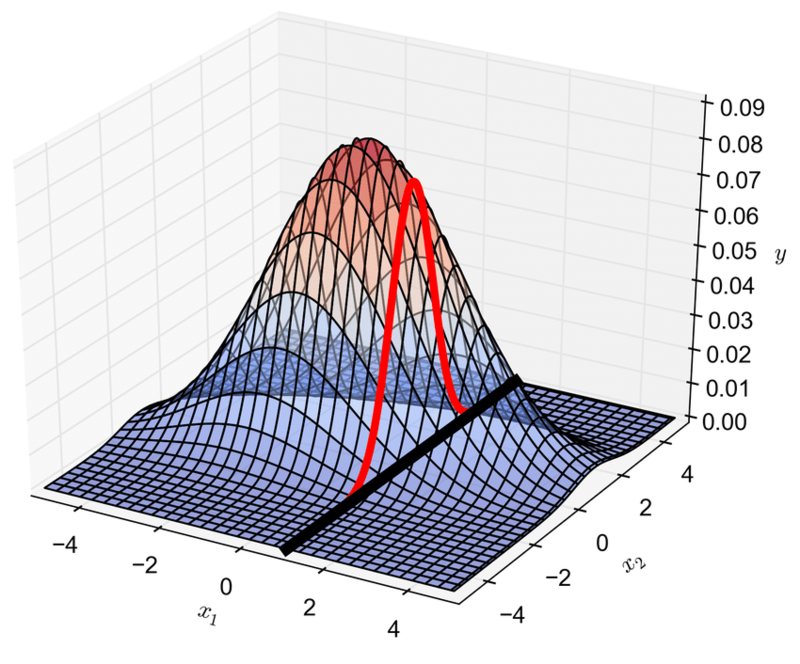

In [4]:
Image(filename='figs/cond.png', width=500)

## Functions described as multivariate Gaussians

- A function: $f: x \rightarrow y$, $f(x) = y$
- We define a multivariate Gaussian for all possible values of $f(x)$, $x \in X$:
$$
    \begin{pmatrix}
    f(x_1) & ... &f(x_n)
    \end{pmatrix} ^T
    =
    \mathcal{N}\bigg(
        \begin{pmatrix}
            \mu & ... & \mu
        \end{pmatrix} ^T
        ,
        \begin{pmatrix}
            \sigma_{11} & ... & \sigma_{1n} \\
            \vdots & \vdots & \vdots \\
            \sigma_{n1} & ... & \sigma_{nn} \\
        \end{pmatrix} ^T
    \bigg)
$$
    - $\mu_i$ is the expected value of $f(x_i)$.
    - The size $n$ is not fixed and can be considered for every $x$.

Below is an example. In total we have $n=50$ points from a sample of Gaussian, and the outputs are connected with line segments.
- The mean vector is given by a sin function
- the covariance is almost zero. So the random draw is almost fixed and deterministic.

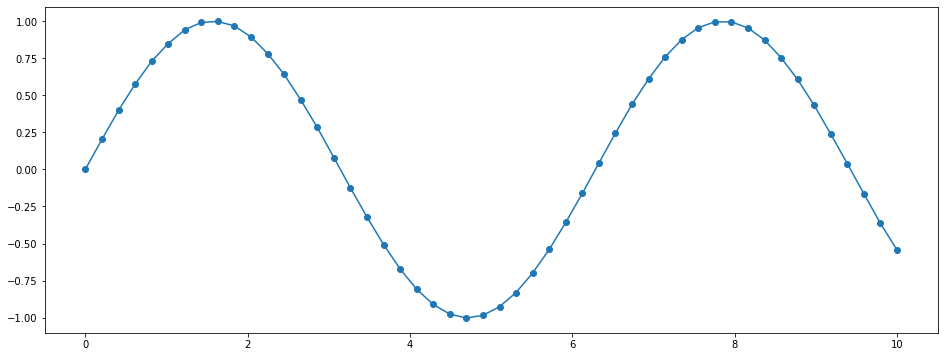

In [5]:
n = 50
x = np.linspace(0, 10, n)

# Define the gaussian with mu = sin(x) and negligible covariance matrix
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) * 1e-6)
plt.figure(figsize=(16, 6))

# Taking a sample from the distribution and plotting it.
plt.plot(x, norm.rvs(), 'o-');

- Now the covariance is not zero.
- multiple draws from the same normal distribution. Due to a large covariance, some variation appear.
- the covariance matrix is diagonal, which means $f_i$ and $f_j$ are mutually **independent**.

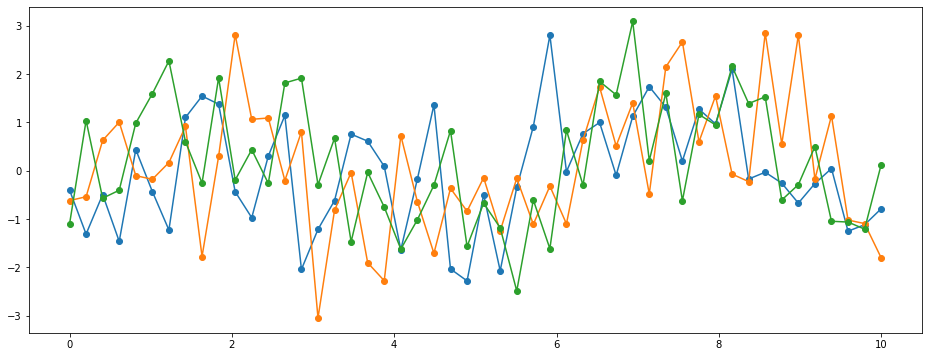

In [6]:
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) )

plt.figure(figsize=(16, 6))
# Taking a sample from the distribution and plotting it.
[ plt.plot(x, norm.rvs(), 'o-') for _ in range(3) ];

- the mean vector $[\mu_i]$ is zeros below with the same covariance.

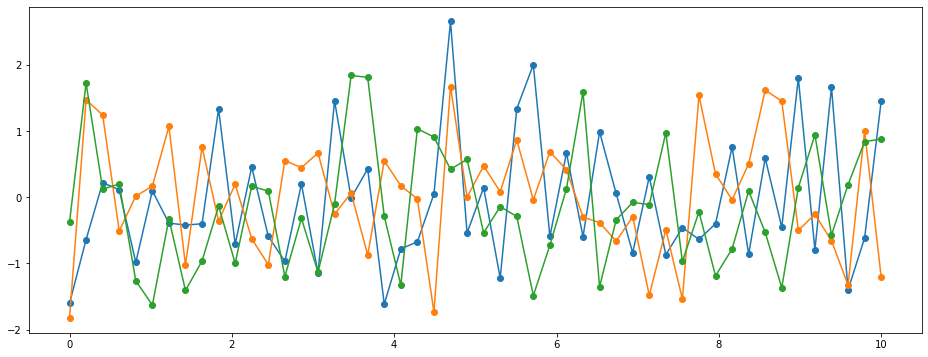

In [7]:
norm = stats.multivariate_normal(mean=np.zeros(n), cov=np.eye(n) )

plt.figure(figsize=(16, 6))
# Taking a sample from the distribution and plotting it.
[ plt.plot(x, norm.rvs(), 'o-') for _ in range(3) ];

## Controlling the functions with kernels
- We want a relation (correlation) between $f_i$ and $f_j$. For example, we may want to draw samples from a smooth function.
- We can do it by setting the covariance matrix $\Sigma$.

### Squared exponential kernel
- Here, kernel means covariance matrix as a function of $x$ (or $x_i$ and $x_j$)
$$
    k(x, x') = \exp\bigg({-\frac{(x-x')^2}{2l^2}}\bigg)
$$

In [8]:
def kernel(x, xp, l=.1):
    # the kernel may found to be almost singuar. Don't worry about it now.
    # One 
    return np.exp( - (x.reshape(-1,1) - xp)**2 / (2*l*l))
    
cov=kernel(x, x, l=.44)
print(cov[:3, :3])

[[1.         0.89801781 0.65033901]
 [0.89801781 1.         0.89801781]
 [0.65033901 0.89801781 1.        ]]


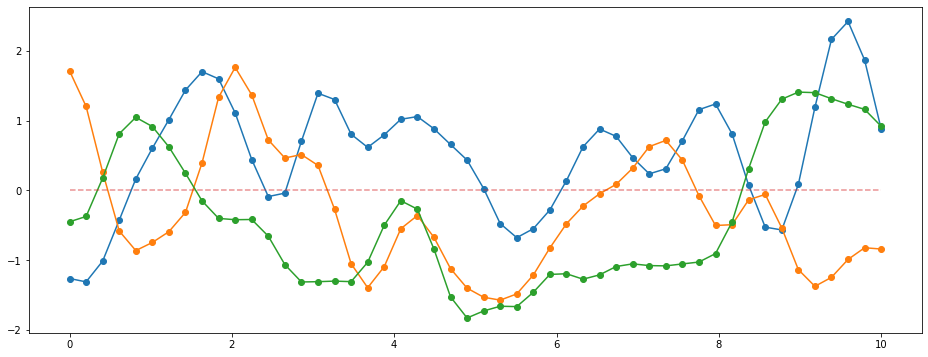

In [12]:
norm = stats.multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16,6))
[plt.plot(x, norm.rvs(), 'o-') for _ in range(3)];
plt.plot([0,10], [0,0], '--', alpha=.5);

## GP

$$
    x=[x_1, ..., x_N] \rightarrow \mu(x), cov(x) \rightarrow \mathcal{N}(\mu(x), cov(x))  \rightarrow f(x) \sim \mathcal{N}(\mu(x), cov(x))
$$

### Setup

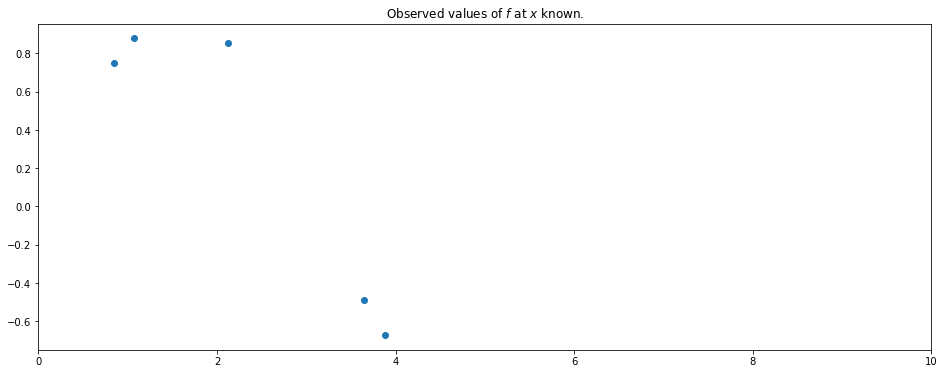

In [62]:
np.random.seed(512)
# True function, but unknown
f = lambda x: np.sin(x)

# Known domain of true function f
x = np.random.uniform(0, 10, 5)
fx = f(x)                         # observations at x

plt.figure(figsize=(16, 6))
plt.scatter(x, f(x))
plt.xlim(0, 10); plt.title('Observed values of $f$ at $x$ known.');

### Prior Probability of $f_*$
- It is a multivariate Gaussian, defined by $\mu_*$ and $k_{**}$.
- We are going to compute posterior of $f_*$ given $f$.
- Cholesky decomposition: $K = L  L^T$

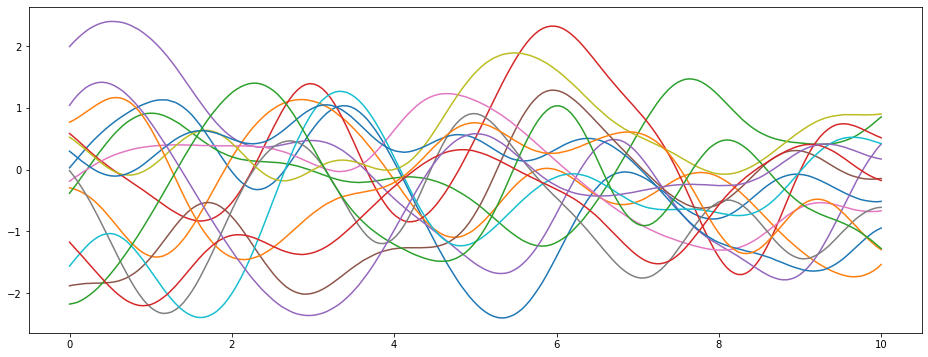

In [42]:
x_s = np.linspace(0, 10, 200)  # domain of f_*
# covariance prior
lvalue = .8
K_ss = kernel(x_s, x_s, l=lvalue)
# 
# draw 15 samples from the prior multivariate Gaussian distribution
norm = stats.multivariate_normal(mean=np.zeros_like(x_s), cov=K_ss + 1e-6*np.eye(x_s.size))
f_prior = norm.rvs(15).T
plt.figure(figsize=(16, 6))
plt.plot(x_s, f_prior);

Another way of drawing samples from the multivariate normal is to use cholesky decomposition of K_ss, and transform samples from $\mathcal{N}(0,1)$:
$$
    f \sim 0_n + L z, \quad z \sim \mathcal{N}(0,I_n) \quad LL^T = K_{ss}
$$
Notice that 
- the  prior mean is modeled to be $0_n$
- the random draw vector $z$ may also be composed of $n$ independent samples from $\mathcal{N}(0,1)$.

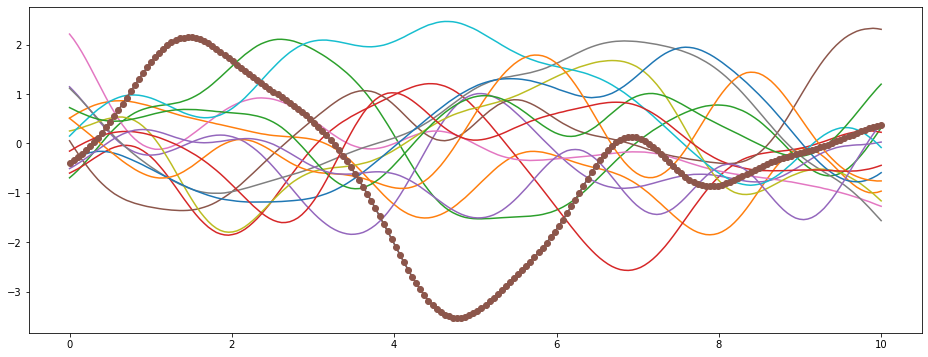

In [38]:
L_ss= np.linalg.cholesky(K_ss + 1e-6*np.eye(x_s.size))
# draw 15 samples from prior
f_prior = np.dot(L_ss, np.random.normal(size=(x_s.size, 15))); f_prior.shape
plt.figure(figsize=(16, 6)); plt.plot(x_s, f_prior);
plt.plot(x_s, f_prior[:,0], 'o-');

### Posterior Probability Density
1. We want to draw new samples $f_*$ at $x_*$ based on the known values of $f$ at $x$.
1. We built a model already, which was a multivariate normal.

- $K = k(x,x)$
- $K_* = k(x, x_*)$
- $K_{**} = k(x_*, x_*)$
- mean: $\mu_{f_*|f} = \mu_* = k_*^T \alpha$ where  $ \alpha = L^{-T} L^{-1} f $

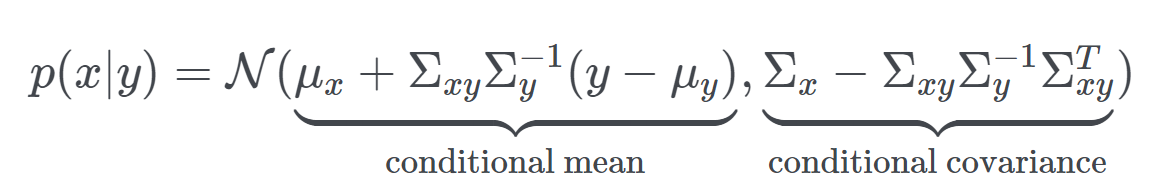

In [39]:
Image(filename='figs/cond_eq.png', width=500)

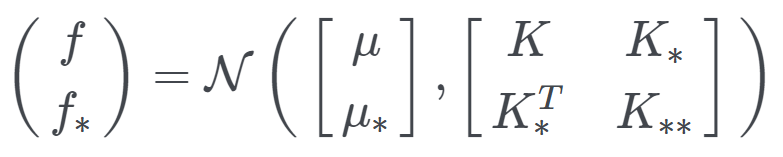

In [40]:
Image(filename='figs/cond_eq_2.png', width=500)

The posterior normal given the observation vector $f$ at $x$ is defined by the following parameters:
$$
\mu_{f_* | f} = \mu_* + K_* K^{-1} (f - \mu_*) \\
K_{f_* | f} = K_{**} - K_* K^{-1} K_*^T \\
K_* = kernel(x_*, x)
$$

In [66]:
K = kernel(x, x, lvalue)
invK = np.linalg.inv(K)
K_s = kernel(x_s, x, lvalue); print('K_s', K_s.shape)
# conditional mean
mu_cond = 0 + K_s @ invK @ (fx - 0); print('mu_s', mu_s.shape)  # fx is the observation vector at x
# conditional covariance
K_cond = K_ss - K_s @ invK @ K_s.T
# np.linalg.eigvals(K_cond)

K_s (200, 5)
mu_s (200,)


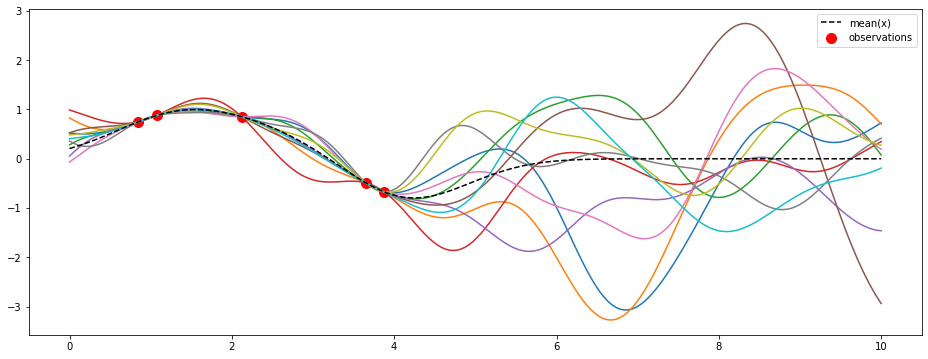

In [97]:
# draw posterior samples
norm_cond = stats.multivariate_normal(mean=mu_cond, cov=K_cond, allow_singular=True)
s = norm_cond.rvs(10) # draw 10 samples
plt.figure(figsize=(16, 6)); 
plt.plot(x_s, s.T);
plt.scatter(x, fx, color='r', s=100, label='observations');  # observation
plt.plot(x_s, mu_cond, 'k--', label='mean(x)');
plt.legend();

At each point $x$, its variance is given by its diagonal term in $K_{cond}$.

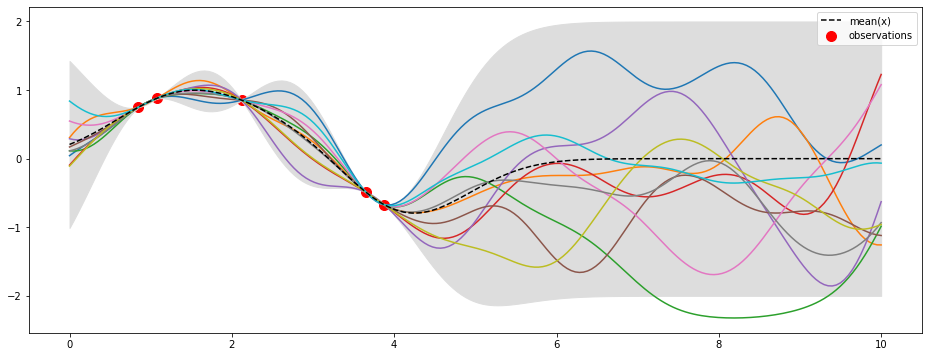

In [112]:
std_cond = np.sqrt(np.diag(K_cond))

# draw posterior samples
norm_cond = stats.multivariate_normal(mean=mu_cond, cov=K_cond, allow_singular=True)
s = norm_cond.rvs(10) # draw 10 samples

plt.figure(figsize=(16, 6)); 
plt.plot(x_s, s.T);
plt.scatter(x, fx, color='r', s=100, label='observations');  # observation
plt.plot(x_s, mu_cond, 'k--', label='mean(x)');
plt.legend();
#
plt.fill_between(x_s, mu_cond - 2*std_cond, mu_cond + 2*std_cond, color='#dddddd', label='+/- 2std');

## GP with Observation Noise

Now let's consider when the observation $f$ is noisy, contaminated by white gaussian noise:
$$
    y = f(x) + \epsilon, \quad \epsilon\sim\mathcal{N}(0,\sigma_y^2)
$$
The covariance of the observed noisy responses is 
$$
    cov(y_i, y_j) = \kappa(x_i, x_j) + \sigma_y^2 \delta_{ij}
$$

In [116]:
# covariance model with observation noise
sigma_y = .1
K = kernel(x, x, lvalue) + np.eye(x.size)*sigma_y**2
invK = np.linalg.inv(K)
# the other parts are all the same
K_s = kernel(x_s, x, lvalue); print('K_s', K_s.shape)
# conditional mean
mu_cond = 0 + K_s @ invK @ (fx - 0); print('mu_s', mu_s.shape)  # fx is the observation vector at x
# conditional covariance
K_cond = K_ss - K_s @ invK @ K_s.T
# np.linalg.eigvals(K_cond)

K_s (200, 5)
mu_s (200,)


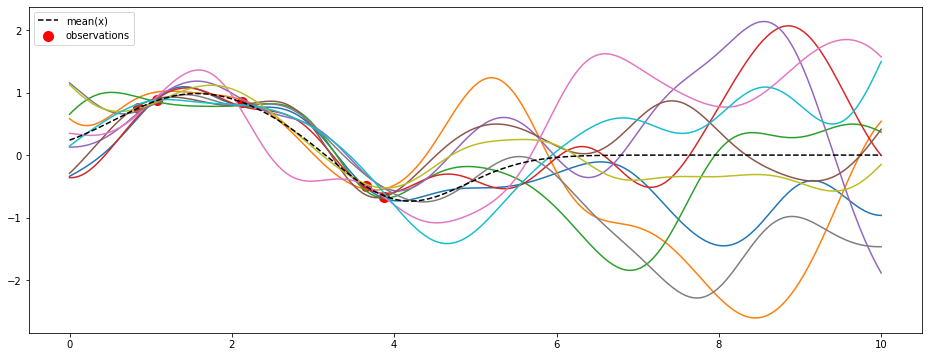

In [117]:
# draw posterior samples
norm_cond = stats.multivariate_normal(mean=mu_cond, cov=K_cond, allow_singular=True)
s = norm_cond.rvs(10) # draw 10 samples
plt.figure(figsize=(16, 6)); 
plt.plot(x_s, s.T);
plt.scatter(x, fx, color='r', s=100, label='observations');  # observation
plt.plot(x_s, mu_cond, 'k--', label='mean(x)');
plt.legend();

At each point $x$, its variance is given by its diagonal term in $K_{cond}$.

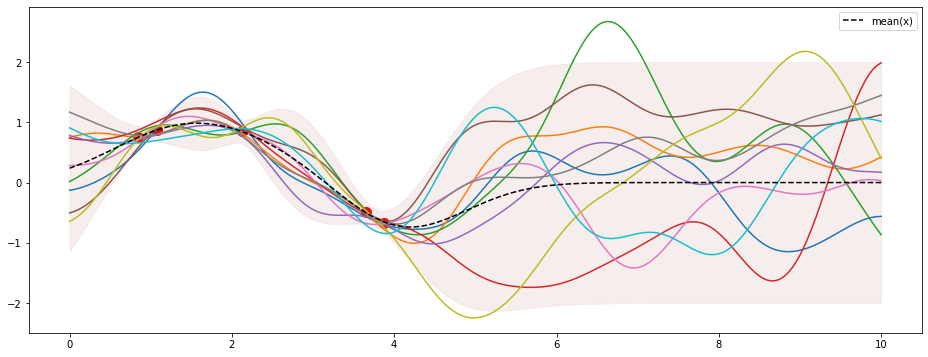

In [126]:
std_cond = np.sqrt(np.diag(K_cond))

# draw posterior samples
norm_cond = stats.multivariate_normal(mean=mu_cond, cov=K_cond, allow_singular=True)
s = norm_cond.rvs(10) # draw 10 samples
plt.figure(figsize=(16, 6)); 
plt.plot(x_s, s.T);
plt.plot(x_s, mu_cond, 'k--', label='mean(x)');
plt.legend();
#
plt.fill_between(x_s, mu_cond - 2*std_cond, mu_cond + 2*std_cond, color='#eedddd', label='+/- 2std', alpha=.5);
plt.scatter(x, fx, color='r', s=100, label='observations');  # observation

## Key issues
1. what kind of covariance kernel can we model?
2. how to determine the parameters of the kernel and $\sigma_y$ to fit the model to data?